# COVID19 CT Dataset을 활용한 Transfer Learning

## Import

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

In [2]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = os.path.join(os.getenv('HOME'),'covid_data/CT')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [4]:
print(type(image_datasets))
print()
print(image_datasets)
print()
print(image_datasets['train'])

<class 'dict'>

{'train': Dataset ImageFolder
    Number of datapoints: 61973
    Root location: /home/aiffel0042/covid_data/CT/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 21096
    Root location: /home/aiffel0042/covid_data/CT/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}

Dataset ImageFolder
    Number of datapoints: 61973
    Root location: /home/aiffel0042/covid_data/CT/train
    StandardTransform
Transform: Compose(
 

In [5]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [6]:
print(type(dataloaders))
print()
print(dataloaders)
print()
print(dataloaders['train'])

<class 'dict'>

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f444c590a30>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f43b5a32220>}



In [7]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(type(dataset_sizes),end='\n\n')
print(dataset_sizes,end='\n\n')
print(dataset_sizes['train'])

<class 'dict'>

{'train': 61973, 'val': 21096}

61973


In [8]:
class_names = image_datasets['train'].classes
print(type(class_names))
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(type(device))
print(device)

<class 'list'>
['covid-19', 'normal', 'pneumonia']
<class 'torch.device'>
cuda:0


## Visualization

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

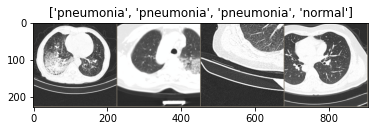

In [10]:
# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
print(inputs.shape)
print(type(inputs))

torch.Size([4, 3, 224, 224])
<class 'torch.Tensor'>


In [12]:
# model-> model , criterion -> loss function(Cross-Entropy), optimizer -> SGD , sheduler ->LR sheduler
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    #현재 시간 받아오기
    since = time.time()
    
    #model.state_dict()는 OrderedDict으로 model의 다양한 정보가 있음
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 3로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, len (class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2328 Acc: 0.9183
val Loss: 0.0581 Acc: 0.9818

Epoch 1/24
----------
train Loss: 0.0996 Acc: 0.9656
val Loss: 0.1561 Acc: 0.9607

Epoch 2/24
----------
train Loss: 0.0774 Acc: 0.9724
val Loss: 0.0798 Acc: 0.9747

Epoch 3/24
----------
train Loss: 0.0641 Acc: 0.9773
val Loss: 0.0690 Acc: 0.9751

Epoch 4/24
----------
train Loss: 0.0581 Acc: 0.9791
val Loss: 0.1001 Acc: 0.9687

Epoch 5/24
----------
train Loss: 0.0502 Acc: 0.9819
val Loss: 0.0932 Acc: 0.9758

Epoch 6/24
----------
train Loss: 0.0461 Acc: 0.9836
val Loss: 0.0404 Acc: 0.9860

Epoch 7/24
----------
train Loss: 0.0310 Acc: 0.9890
val Loss: 0.0464 Acc: 0.9857

Epoch 8/24
----------
train Loss: 0.0271 Acc: 0.9907
val Loss: 0.0561 Acc: 0.9819

Epoch 9/24
----------
train Loss: 0.0266 Acc: 0.9905
val Loss: 0.0487 Acc: 0.9844

Epoch 10/24
----------
train Loss: 0.0244 Acc: 0.9914
val Loss: 0.0722 Acc: 0.9766

Epoch 11/24
----------
train Loss: 0.0235 Acc: 0.9920
val Loss: 0.0301 Acc: 0.9906

Ep

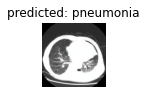

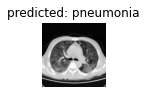

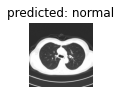

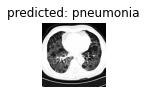

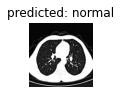

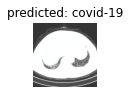

In [16]:
visualize_model(model_ft)

In [23]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, real: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

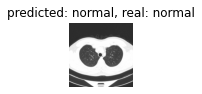

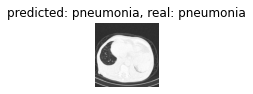

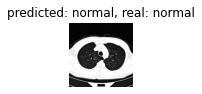

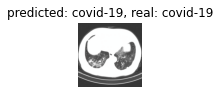

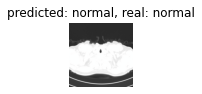

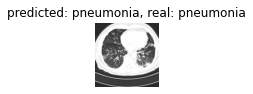

In [39]:
visualize_model(model_ft)

In [42]:
data_transforms_test = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = os.path.join(os.getenv('HOME'),'covid_data/CT')
image_datasets_test = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms_test[x])
                  for x in ['test']}

In [43]:
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets_test[x], batch_size=4,
                                             shuffle=False, num_workers=4)
              for x in ['test']}

In [45]:
def test_acc(model):
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_test['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]): # input.size 0 번째 : 배치 사이즈
                total +=1
                #print('predicted: {}, real: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                if preds[j]==labels[j]:
                    correct+=1
    print('final test accuracy is {}%'.format(correct/total*100))

In [46]:
test_acc(model_ft)

final test accuracy is 99.55376015782798%
